Importing Functions

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os


In [224]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [225]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [226]:
# List current working directory
print(os.getcwd())

/


In [227]:
# List all files and folders
print(os.listdir())

['home', 'usr', 'bin', 'sbin', '.file', 'etc', 'var', 'Library', 'System', '.VolumeIcon.icns', 'private', '.vol', 'Users', 'Applications', 'opt', 'dev', 'Volumes', 'tmp', 'cores']


In [228]:
#Loading Datasets
train_data = pd.read_csv("/Users/shivamverma/Downloads/titanic/train.csv")
test_data = pd.read_csv("/Users/shivamverma/Downloads/titanic/test.csv")

In [229]:
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [230]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


 Data Preprocessing

In [231]:
# Filling up the Missing Values
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)  # Additional fix

train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Embarked'].fillna(test_data['Embarked'].mode()[0], inplace=True)

# Converting the categorical variables
train_data = pd.get_dummies(train_data, columns=['Embarked'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Embarked'], drop_first=True)

train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})

Feature Engineering

In [232]:
# Creating the Family Size Feature
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

# Creating IsAlone Feature
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

# Extracting Titles from Names
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train_data['Title'] = train_data['Title'].replace(rare_titles, 'Rare')
test_data['Title'] = test_data['Title'].replace(rare_titles, 'Rare')

title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
train_data['Title'] = train_data['Title'].map(title_mapping).fillna(0)
test_data['Title'] = test_data['Title'].map(title_mapping).fillna(0)


Data Visualization

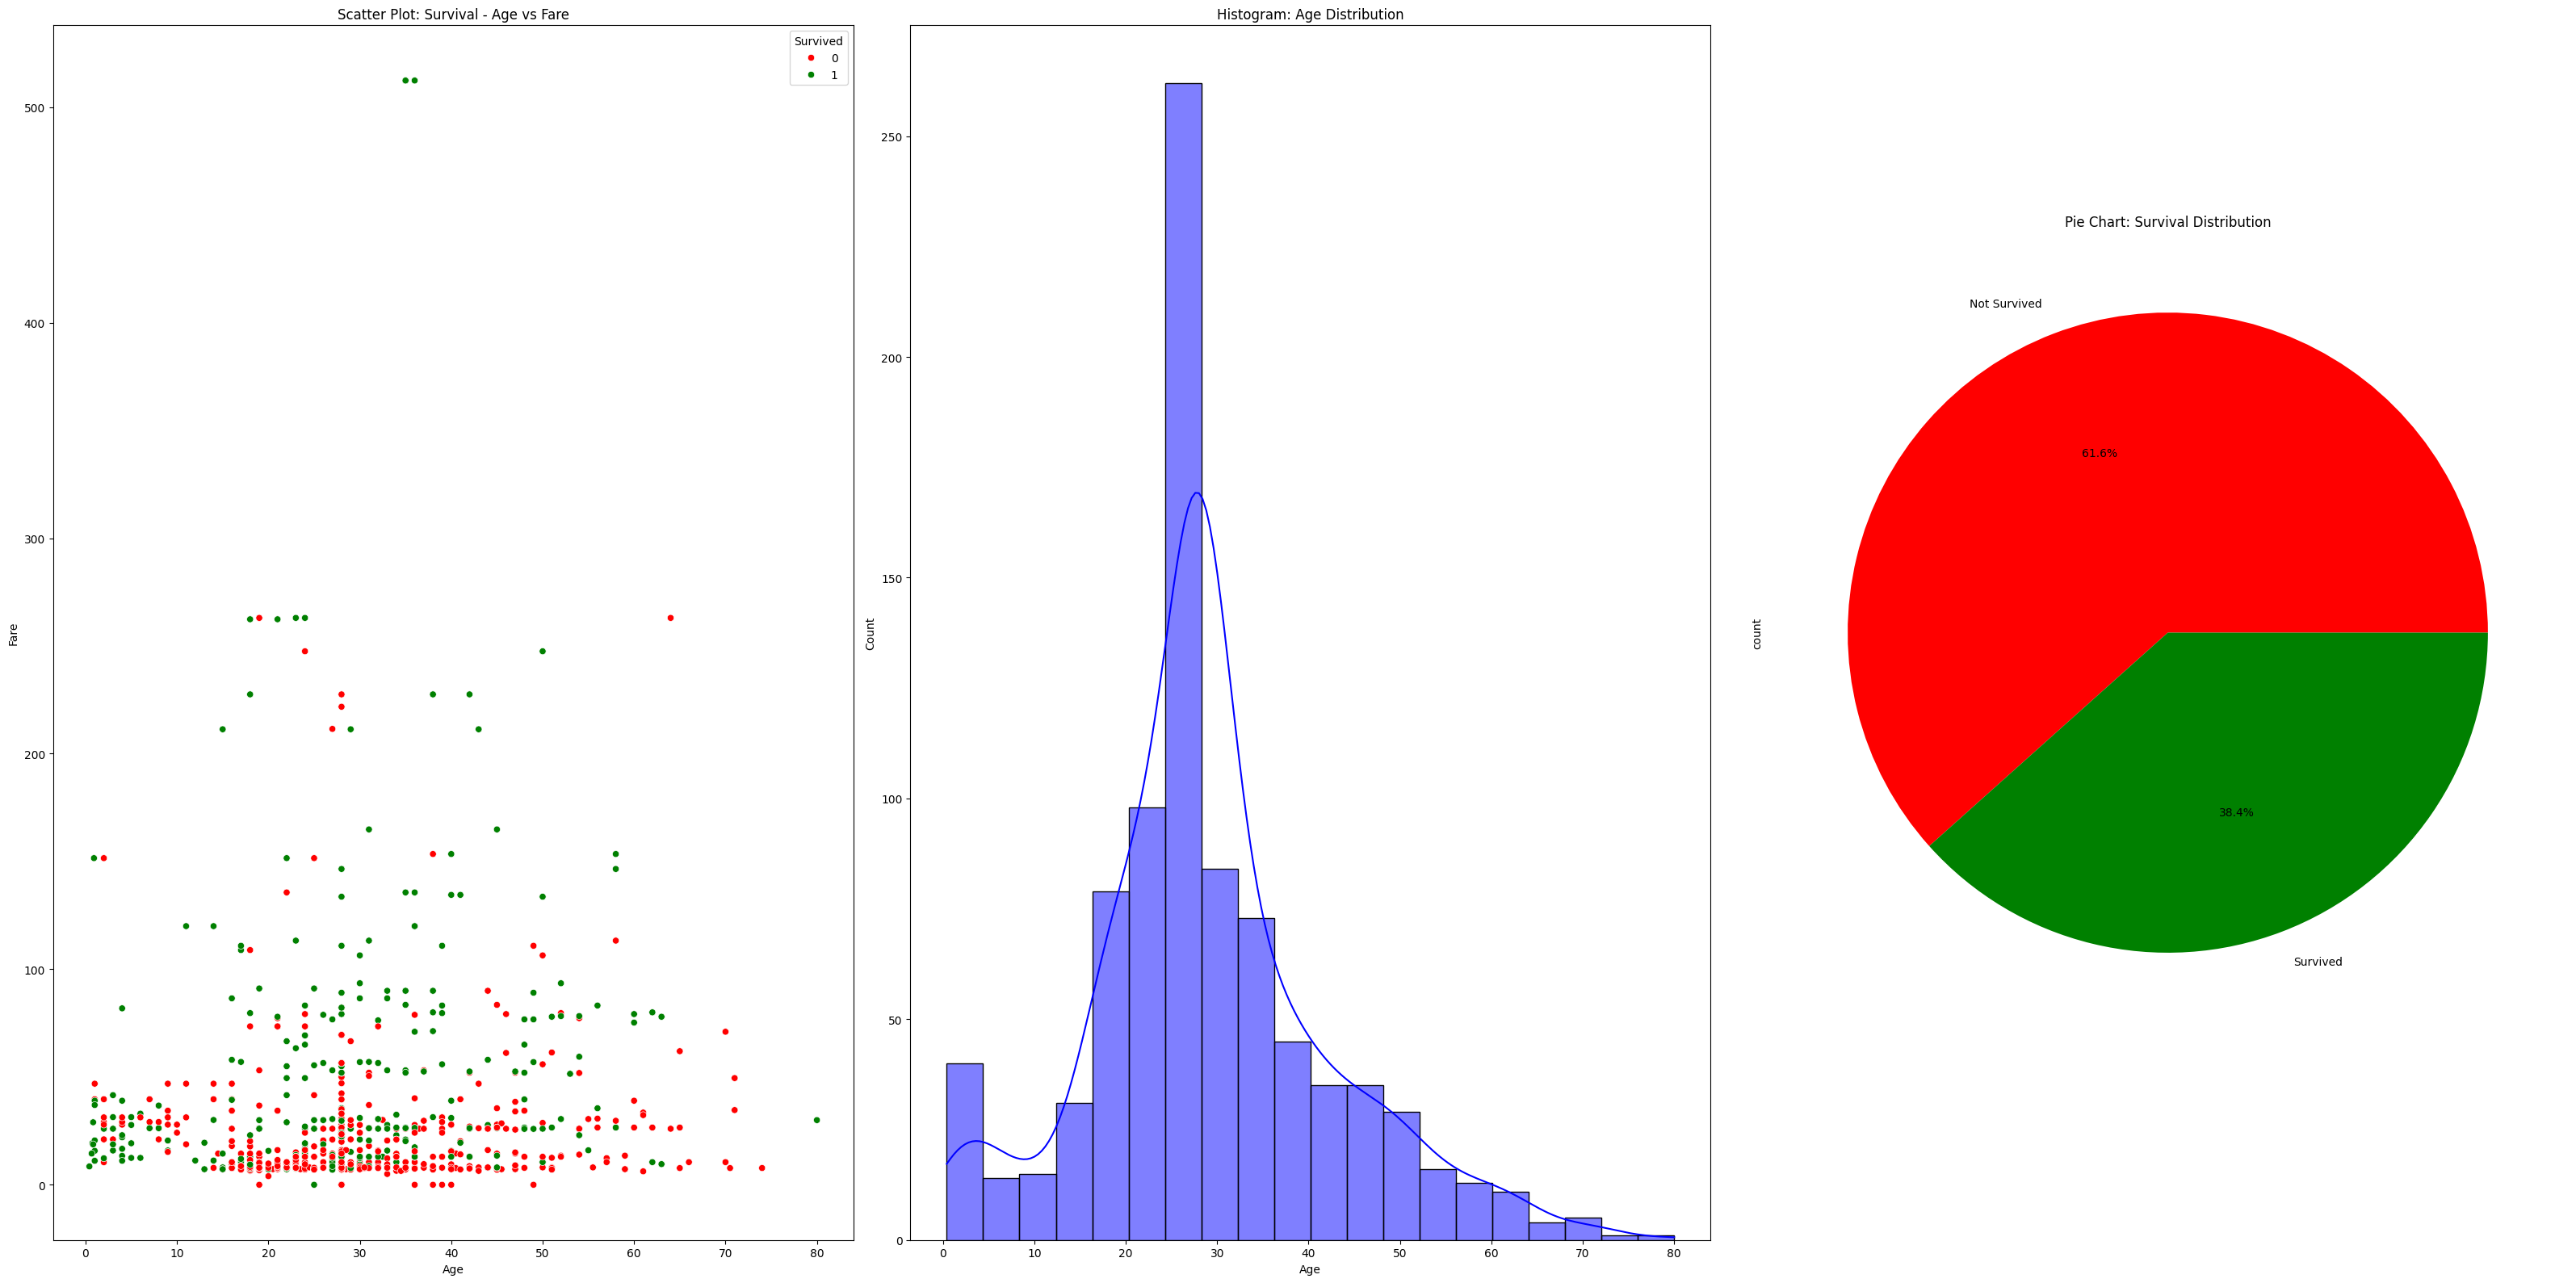

In [233]:
plt.figure(figsize=(32, 16))

# Scatter Plot: Survival vs Age and Fare
plt.subplot(1, 3, 1)
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train_data, palette={0: 'red', 1: 'green'})
plt.title("Scatter Plot: Survival - Age vs Fare")

# Histogram: Age Distribution
plt.subplot(1, 3, 2)
sns.histplot(train_data['Age'], kde=True, bins=20, color="blue")
plt.title("Histogram: Age Distribution")

# Pie Chart: Survival Distribution
plt.subplot(1, 3, 3)
train_data['Survived'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Not Survived', 'Survived'], colors=['red', 'green'])
plt.title("Pie Chart: Survival Distribution")

plt.tight_layout()
plt.show()


In [234]:
# Outlier Detection & Handling: Using IQR (Interquartile Range) to remove outliers

Q1 = train_data['Fare'].quantile(0.25)
Q3 = train_data['Fare'].quantile(0.75)
IQR = Q3 - Q1
train_data = train_data[(train_data['Fare'] >= (Q1 - 1.5 * IQR)) & (train_data['Fare'] <= (Q3 + 1.5 * IQR))]


In [235]:
# Feature Scaling: Normalize continuous variables using StandardScaler:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data[['Age', 'Fare']] = scaler.fit_transform(train_data[['Age', 'Fare']])
test_data[['Age', 'Fare']] = scaler.transform(test_data[['Age', 'Fare']])

In [236]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load Data
train_data = pd.read_csv("/Users/shivamverma/Downloads/titanic/train.csv")

# Drop unnecessary columns
X = train_data.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = train_data['Survived']

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Train size: 623, Validation size: 134, Test size: 134


In [237]:
# Check if 'Embarked' exists before encoding
if 'Embarked' in train_data.columns:
    train_data = pd.get_dummies(train_data, columns=['Embarked'], drop_first=True)

if 'Embarked' in test_data.columns:
    test_data = pd.get_dummies(test_data, columns=['Embarked'], drop_first=True)


In [238]:
# Align test_data columns with train_data (add missing columns)
missing_cols = set(train_data.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0  # Add missing columns with 0s

# Ensure columns match in order
test_data = test_data[train_data.columns.drop('Survived', errors='ignore')]


In [239]:
# Check if 'Embarked' exists in train and test data
print("Train Columns:", train_data.columns)
print("Test Columns:", test_data.columns)

# If 'Embarked' is missing, reload the dataset or check preprocessing steps
if 'Embarked' not in train_data.columns:
    print("Warning: 'Embarked' column is missing from train_data!")

if 'Embarked' not in test_data.columns:
    print("Warning: 'Embarked' column is missing from test_data!")


Train Columns: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked_Q', 'Embarked_S'],
      dtype='object')
Test Columns: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [240]:
# Ensure 'Embarked' exists before encoding
if 'Embarked' in train_data.columns:
    train_data = pd.get_dummies(train_data, columns=['Embarked'], drop_first=True)
else:
    train_data['Embarked'] = 'S'  # Default most common value, then encode
    train_data = pd.get_dummies(train_data, columns=['Embarked'], drop_first=True)

if 'Embarked' in test_data.columns:
    test_data = pd.get_dummies(test_data, columns=['Embarked'], drop_first=True)
else:
    test_data['Embarked'] = 'S'  # Default most common value, then encode
    test_data = pd.get_dummies(test_data, columns=['Embarked'], drop_first=True)


Partition Data (Train/Validation/Test)

In [246]:
X = train_data.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = train_data['Survived']


, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nTrain size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")



Train size: 623, Validation size: 134, Test size: 134


In [247]:
#Linear Classifier Start
lSVCmodel = LinearSVC(random_state=42)
lSVCmodel.fit(X_train, y_train)

y_lSVC_pred = lSVCmodel.predict(X_val)
print(f"Model 1 - Linear SVC")
print(f'Accuracy: {accuracy_score(y_val, y_lSVC_pred)}')
print(f'F1-score: {f1_score(y_test, y_lSVC_pred)}')
print(f'AUC: {roc_auc_score(y_test, lSVCmodel.predict_proba(X_test)[:, 1] if hasattr(lSVCmodel, "predict_proba") else y_lSVC_pred)}')
print("\n")

ValueError: could not convert string to float: 'male'